### Homework03 - Reinforcement Learning_part 2

student name : Daniele Mellino <br>
student id : 2013373<br>
Course: Neural Network and Deep Learning <br>
Professor: Testolin Alberto<br>

# Libraries and function to make it work on Colab

In [6]:
!pip install gym
!pip install optuna

     |████████████████████████████████| 308 kB 25.0 MB/s 
     |████████████████████████████████| 80 kB 8.8 MB/s 
     |████████████████████████████████| 210 kB 54.8 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 113 kB 53.4 MB/s 
     |████████████████████████████████| 149 kB 51.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=7440f77033ab7192e48b601308fa0c610898943addff5e1b40a8ebca8a1070c2
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [7]:
import random
import torch
import numpy as np
import gym
import cv2
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from PIL import Image
from IPython.display import clear_output
import optuna
from optuna.trial import TrialState

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

#enable virtual rendering
import gc
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
#from pyvirtualdisplay import Display
from gym.wrappers import Monitor
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


## Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [8]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [9]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [10]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [11]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [12]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Policies and ReplayMemory

In [13]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state,action,next_state,reward) )

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

NOTE: there is a difference wrt paper in that they do not exclude the best action when chosing the action at random

In [14]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

> **HINT**
>
> To sample from a random (discrete) distribution you can use the numpy function `numpy.random.choice` (https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html), by setting the parameter `p` properly.

> **HINT**
>
> Even if the PyTorch softmax function does not support the temperature parameter directly, you can still use it and apply the temperature outside the function. Just look carefully at the softmax formula in the slide above.

> **HINT**
>
> The softmax function may be numerically unstable with very low temperature values. In practice, it is suggested to set a minimum value for the temperature (e.g. 1e-8).

In [15]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

# PIXEL- Cart Pole


## pre processing

In [17]:
def crop_BB_honest(env, scale = 0.5):
    #convert to black since color mean nothing
    #crop the picture horizontally to reduce dimensions
    
    img       = env.render(mode='rgb_array') #return img 400x600
    #convert to B/W
    img_g   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #crop the image vertically
    cropped    = img_g[168:320, 0:600]

    #rescale the dim of some percent
    #calculate the some percent of original dimensions with proper proportions
    width  = int(cropped.shape[1] * scale )
    height = int(cropped.shape[0] * scale)
    img_g_rescaled = cv2.resize(cropped, (width, height), interpolation = cv2.INTER_AREA )
    img_g_rescaled[img_g_rescaled < 255] = 0
    img_g_rescaled = img_g_rescaled / 255
    
    return img_g_rescaled

def crop_BB(env, scale = 0.5):
    '''
    since env contain the position, I "cheat" using it to cut the images in the right position, 
    this is to save time in computation and memory(smaller frames)
    '''
    #convert to black since color mean nothing
    #crop the picture horizontally to reduce dimensions
    
    img       = env.render(mode='rgb_array') #return img 400x600
    #convert to B&W
    img_g   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #crop the image vertically
    
    
    #cheating crop
    sf = 600/(2*env.x_threshold)
    x   = int(env.state[0]*sf) + 300#300 -> half size 
    left  = int(x) - 42
    right = int(x) + 42

    if left < 0:
        left  = 0
        right = 84
    elif right > 600:
        left  = 600 - 84
        right = 600
    cropped    = img_g[168:320, left:right]
    #rescale the dim of some percent
    #calculate the some percent of original dimensions with proper proportions
    width  = int(cropped.shape[1] * scale )
    height = int(cropped.shape[0] * scale)
    img_g_rescaled = cv2.resize(cropped, (width, height), interpolation = cv2.INTER_AREA )
    img_g_rescaled[img_g_rescaled < 255] = 0
    img_g_rescaled = img_g_rescaled / 255
    
    return img_g_rescaled


def frame_to_tensor(frame):
    return torch.tensor(frame).type(torch.float).unsqueeze(0)


Size of the cropped image is:  (76, 42)


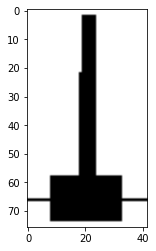

In [18]:
env = gym.make('CartPole-v1') 
env.seed(seed)
state = env.reset()
#image example of crop 
img = crop_BB(env, 0.5)
print("Size of the cropped image is: ", img.shape)
plt.imshow(img, cmap='gist_gray')
plt.show()

## model

In [19]:
class DQCNN(nn.Module):

    def __init__(self, action_space_dim=2,nf=4):
        super().__init__()
    
        self.conv = nn.Sequential(  #76,42
                                    nn.Conv2d(nf, nf*4, kernel_size=(8,4), padding=(0,1), stride=(4,3)), 
                                    nn.ReLU(),
                                    # 18x 13
                                    # Second convolutional layer
                                    nn.Conv2d(nf*4, nf*8, kernel_size=(6,2), padding=0, stride=3), 
                                    nn.ReLU(),
                                    #  5 4
                                    # Flatten layer  5x4
                                    nn.Flatten(start_dim=1)
                                    )
        
        self.linear = nn.Sequential(
                                    nn.Linear(nf*25*8, 250),
                                    nn.ReLU(),
                                    nn.Linear(250, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        x = self.conv(x)
        x = self.linear(x)
        return x


In [20]:
# Define an example network
net = DQCNN(nf=4)
net


DQCNN(
  (conv): Sequential(
    (0): Conv2d(4, 16, kernel_size=(8, 4), stride=(4, 3), padding=(0, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(6, 2), stride=(3, 3))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=800, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

## initialization

In [21]:
##initialization


# Set random seeds
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 2000   # Replay memory capacity
lr = 1e-3   # Optimizer learning rate
target_net_update_steps = 5   # Number of episodes to wait before updating the target network
batch_size = 16   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 200   # Minimum samples in the replay memory to enable the training



In [22]:
def initialize_networks(n_frames = 1, action_space_dim = 2, replay_memory_capacity = replay_memory_capacity):

    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQCNN(nf=n_frames)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQCNN(nf=n_frames)
    
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

## Profile and update step

In [23]:
# so here I create a class Profile which will be usefull to explore different activation

def positive(x,eps = 5e-6):
    if x<eps: return eps
    else: return x

class Profile():
    def __init__(self, type, temperature_max, num_iter):
        '''
        type can be : 
        0 - boltzmann profile
        1 - linear decaying profile 
        '''
        self.ti = temperature_max
        self.num_iter = num_iter
        self.noise_loc = []

        if type ==0 :
            exp_decay = np.exp(-np.log(temperature_max) / num_iter * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
            self.profile = [temperature_max * (exp_decay ** i) for i in range(num_iter)]
        if type == 1 :
            step = int(num_iter / 2)
            m = temperature_max/step
            self.profile = [positive(temperature_max- i*m) for i in range(num_iter) ]
        return 
    
    def add_gnoise(self, mean = None,std = None):
        if mean == None: mean = np.random.randint(1,self.num_iter)
        if std == None: std = self.num_iter/ 60
        A = self.ti * 5
        self.noise_loc.append((mean,std))
        noise = np.array([A*np.exp(-0.5 * (i-mean)**2/std**2)/(std * np.sqrt(2*np.pi)) for i in range(self.num_iter) ])
        self.profile+=noise
        return

    def plot(self):
        plt.plot(self.profile)
        plt.xlabel("Episode number")
        plt.ylabel("Temperature")
        plt.show()
        return
    def _noise_loc(self):
        return self.noise_loc
    def _profile(self):
        return np.array(self.profile)


In [25]:
def update_step(policy_net, target_net, gamma, replay_mem, optimizer, loss_fn, batch_size):
                
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)
    
    # Create tensors for each element of the batch
    states  = torch.tensor([s[0] for s in batch], dtype=torch.float32).clone().detach()
    actions = torch.tensor([s[1] for s in batch], dtype=torch.int64).clone().detach()
    rewards = torch.tensor([s[3] for s in batch], dtype=torch.float32).clone().detach()

    # Compute a mask of non-final states 
    # (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32).clone().detach() 
    
    # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool).clone().detach()

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states.to(device)).cpu()
    
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states.to(device)).cpu()
    
    next_state_max_q_values = torch.zeros(batch_size).clone().detach()
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].clone().detach()

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    # Set the required tensor shape
    expected_state_action_values = expected_state_action_values.unsqueeze(1) 

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()
    
    gc.collect()


## training

In [26]:
def training(explor_profile, n_frames : int,scale: float, update_type : str, printing = True, eps=0.1):
    
    env = gym.make('CartPole-v1') 
    env.seed(seed)
    env.reset()

    frame        = crop_BB(env, scale)
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialize_networks(n_frames = n_frames)
    score_list = []
    frame_history = deque(maxlen=n_frames-1)

    for i in range(n_frames-1): 
        frame_history.append(np.zeros((1, frame.shape[0], frame.shape[1]) ))

    for episode_num, tau in enumerate(tqdm(explor_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        frame = crop_BB(env, scale)[np.newaxis, :]

        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False
        # Go on until the pole falls off
        for i in range(n_frames-1):
            frame = np.append( frame, frame_history[-i-1], axis=0)

        while not done:
            # Adding history
            for i in range(n_frames-1):
                if frame_history[i] is None: 
                    frame_history[i] = np.zeros((1, frame.shape[0], frame.shape[1]))

            frame_history.append(frame[0][np.newaxis, :])
            
            # Choose the action following the policy
            if update_type == 'softmax':
                action, q_values = choose_action_softmax(policy_net, frame_to_tensor(frame), temperature=tau)
            elif update_type == 'greedy': 
                action, q_values = choose_action_epsilon_greedy(policy_net, frame_to_tensor(frame),eps )
            else:
                print("Not valid update rule")
                break

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)
            next_frame = crop_BB(env, scale)[np.newaxis, :]

                
            # update frame history 
            for i in range(n_frames-1):
                next_frame = np.append( next_frame, frame_history[-i-1], axis = 0) 

            # Reward penalty when the cart is far from the centre
            off_cen_penalty = 1.
            reward = reward - off_cen_penalty * np.abs(state[0])

            # Update the final score (+1 for each step)
            score += 1
            
            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward    += bad_state_penalty
                next_state = None
                next_frame = None

            # Update the replay memory
            replay_mem.push(frame, action, next_frame, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, gamma, replay_mem, optimizer, loss_fn, batch_size)

            # Set the current state for the next iteration
            frame = next_frame
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % target_net_update_steps == 0:
    #         print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score only if not doing hyperparams optimization
        if printing == True:
            print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        score_list.append(score)

    env.close()
    
    return np.array(score_list), policy_net

In [27]:
def plot_results(r, p, nframes, upt,sw=100):
    ti = p[0]
    scale = max(r)//ti
    fig, ax = plt.subplots(1,2, figsize = (13,5), sharey = True)
    ax[0].plot(scale*p,  label = "Scaled Profile")
    ax[0].plot(np.array(r), label = 'Score',color="red")
    ax[0].legend()
    ax[0].set_xlabel("Episode")

    mv=np.convolve(r, np.ones(sw), 'valid') / sw
    ax[1].plot(scale*p,  label = "Scaled Profile")
    ax[1].plot(mv, label = "Average score",color="red")
    ax[1].legend()
    ax[1].set_title(f"Moving Average Score for a window of {sw} element")
    ax[1].set_xlabel("Episode")
    ax[1].set_ylabel("Score")

    plt.suptitle(str(nframes) + " consecutive frames and " + str(upt) +" update rule", fontsize = 15)
    plt.show()
    return


# trials

In [91]:
n_frames     = 4
update_type  = 'softmax'
scale        = 0.5 

#initialize the exploration profile
pr = Profile(type = 0, temperature_max = 4 , num_iter= 1000)
profile     = pr._profile()

start_time = time.time()
r4f, net4f = training(profile,
                      n_frames = n_frames,
                      update_type = update_type,
                      scale=scale)
end_time   = time.time()

# clear_output(wait = True)
print("training time: ", end_time - start_time, "s")

  0%|          | 0/1000 [00:00<?, ?it/s]

EPISODE: 1 - FINAL SCORE: 11 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 13 - Temperature: 3.966866922953173
EPISODE: 3 - FINAL SCORE: 37 - Temperature: 3.934008296104994
EPISODE: 4 - FINAL SCORE: 21 - Temperature: 3.901421846110568
EPISODE: 5 - FINAL SCORE: 27 - Temperature: 3.869105318455729
EPISODE: 6 - FINAL SCORE: 15 - Temperature: 3.8370564773010587
EPISODE: 7 - FINAL SCORE: 49 - Temperature: 3.8052731053271978


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


EPISODE: 8 - FINAL SCORE: 36 - Temperature: 3.773753003581442
EPISODE: 9 - FINAL SCORE: 20 - Temperature: 3.742493991325602
EPISODE: 10 - FINAL SCORE: 18 - Temperature: 3.7114939058851326
EPISODE: 11 - FINAL SCORE: 17 - Temperature: 3.6807506024995025
EPISODE: 12 - FINAL SCORE: 15 - Temperature: 3.6502619541738097
EPISODE: 13 - FINAL SCORE: 66 - Temperature: 3.620025851531624
EPISODE: 14 - FINAL SCORE: 34 - Temperature: 3.5900402026690483
EPISODE: 15 - FINAL SCORE: 10 - Temperature: 3.5603029330099885
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 3.5308119851626225
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 3.501565318777059
EPISODE: 18 - FINAL SCORE: 19 - Temperature: 3.472560910404175
EPISODE: 19 - FINAL SCORE: 22 - Temperature: 3.443796753355619
EPISODE: 20 - FINAL SCORE: 41 - Temperature: 3.415270857564983
EPISODE: 21 - FINAL SCORE: 24 - Temperature: 3.386981249450112
EPISODE: 22 - FINAL SCORE: 17 - Temperature: 3.358925971776565
EPISODE: 23 - FINAL SCORE: 14 - Temperature: 3.3311

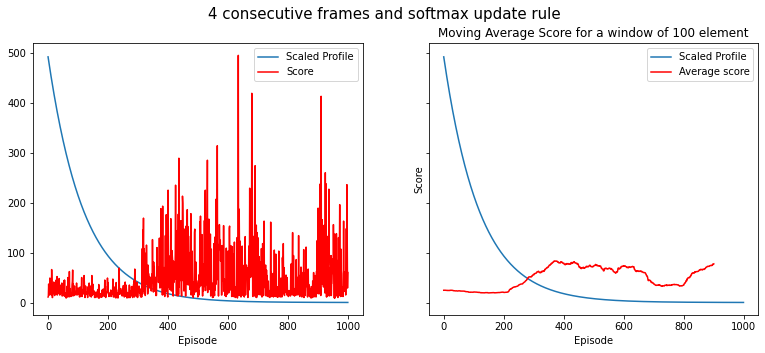

In [92]:
plot_results(r4f, profile, n_frames, update_type)


  0%|          | 0/1000 [00:00<?, ?it/s]

EPISODE: 1 - FINAL SCORE: 11 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 101 - Temperature: 3.966866922953173
EPISODE: 3 - FINAL SCORE: 11 - Temperature: 3.934008296104994
EPISODE: 4 - FINAL SCORE: 16 - Temperature: 3.901421846110568
EPISODE: 5 - FINAL SCORE: 25 - Temperature: 3.869105318455729
EPISODE: 6 - FINAL SCORE: 38 - Temperature: 3.8370564773010587
EPISODE: 7 - FINAL SCORE: 19 - Temperature: 3.8052731053271978
EPISODE: 8 - FINAL SCORE: 22 - Temperature: 3.773753003581442
EPISODE: 9 - FINAL SCORE: 12 - Temperature: 3.742493991325602
EPISODE: 10 - FINAL SCORE: 12 - Temperature: 3.7114939058851326
EPISODE: 11 - FINAL SCORE: 23 - Temperature: 3.6807506024995025
EPISODE: 12 - FINAL SCORE: 9 - Temperature: 3.6502619541738097
EPISODE: 13 - FINAL SCORE: 20 - Temperature: 3.620025851531624
EPISODE: 14 - FINAL SCORE: 19 - Temperature: 3.5900402026690483
EPISODE: 15 - FINAL SCORE: 17 - Temperature: 3.5603029330099885
EPISODE: 16 - FINAL SCORE: 20 - Temperature: 3.5308119851626225
EPISODE

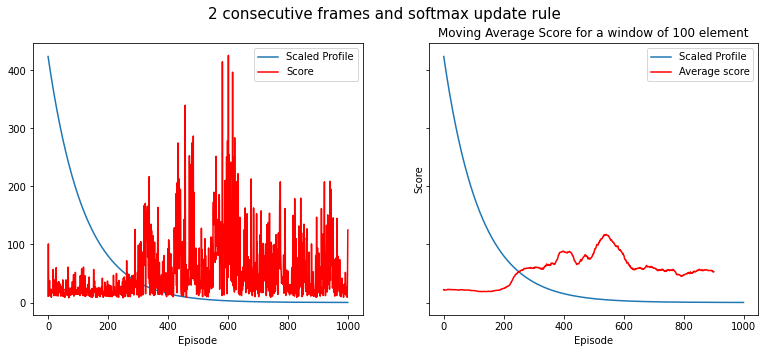

In [95]:
n_frames     = 2

#initialize the exploration profile
pr = Profile(type = 0, temperature_max = 4 , num_iter= 1000)
profile     = pr._profile()

start_time = time.time()
r3f, net3f = training(profile,
                      n_frames = n_frames,
                      update_type = update_type,
                      scale=scale)
end_time   = time.time()

# clear_output(wait = True)
print("training time: ", end_time - start_time, "s")

plot_results(r3f, profile, n_frames, update_type)

  0%|          | 0/1000 [00:00<?, ?it/s]

EPISODE: 1 - FINAL SCORE: 11 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 13 - Temperature: 3.966866922953173
EPISODE: 3 - FINAL SCORE: 37 - Temperature: 3.934008296104994
EPISODE: 4 - FINAL SCORE: 21 - Temperature: 3.901421846110568
EPISODE: 5 - FINAL SCORE: 27 - Temperature: 3.869105318455729
EPISODE: 6 - FINAL SCORE: 15 - Temperature: 3.8370564773010587
EPISODE: 7 - FINAL SCORE: 49 - Temperature: 3.8052731053271978


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


EPISODE: 8 - FINAL SCORE: 36 - Temperature: 3.773753003581442
EPISODE: 9 - FINAL SCORE: 20 - Temperature: 3.742493991325602
EPISODE: 10 - FINAL SCORE: 18 - Temperature: 3.7114939058851326
EPISODE: 11 - FINAL SCORE: 17 - Temperature: 3.6807506024995025
EPISODE: 12 - FINAL SCORE: 15 - Temperature: 3.6502619541738097
EPISODE: 13 - FINAL SCORE: 66 - Temperature: 3.620025851531624
EPISODE: 14 - FINAL SCORE: 34 - Temperature: 3.5900402026690483
EPISODE: 15 - FINAL SCORE: 10 - Temperature: 3.5603029330099885
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 3.5308119851626225
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 3.501565318777059
EPISODE: 18 - FINAL SCORE: 19 - Temperature: 3.472560910404175
EPISODE: 19 - FINAL SCORE: 22 - Temperature: 3.443796753355619
EPISODE: 20 - FINAL SCORE: 41 - Temperature: 3.415270857564983
EPISODE: 21 - FINAL SCORE: 24 - Temperature: 3.386981249450112
EPISODE: 22 - FINAL SCORE: 17 - Temperature: 3.358925971776565
EPISODE: 23 - FINAL SCORE: 14 - Temperature: 3.3311

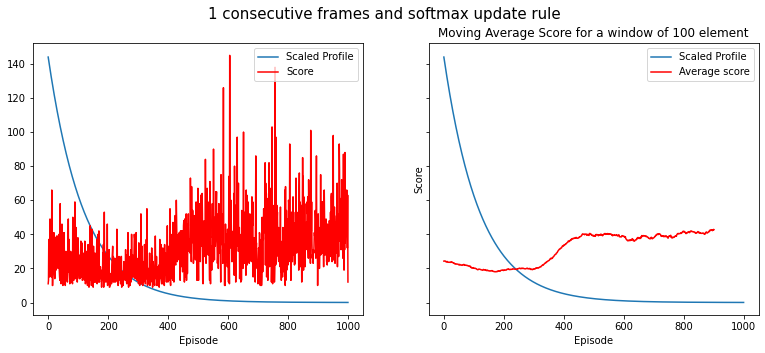

In [24]:
n_frames     = 1

#initialize the exploration profile
pr = Profile(type = 0, temperature_max = 4 , num_iter= 1000)
profile     = pr._profile()

start_time = time.time()
r1f, net1f = training(profile,
                      n_frames = n_frames,
                      update_type = update_type,
                      scale=scale)
end_time   = time.time()

# clear_output(wait = True)
print("training time: ", end_time - start_time, "s")

plot_results(r1f, profile, n_frames, update_type)

In [29]:
prl=[None]*4
profile=[None]*4
r=[None]*4
for n in range(1,5):
    update_type  = 'softmax'
    scale        = 0.5 
    n_frames     = n
    # Set random seeds
    seed = 0
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    #initialize the exploration profile
    prl[n-1]=Profile(type = 0, temperature_max = 4 , num_iter= 500) 
    profile[n-1]     = prl[n-1]._profile()

    r[n-1], _ = training(profile[n-1],
                        n_frames = n_frames,
                        update_type = update_type,
                        scale=scale)



  0%|          | 0/500 [00:00<?, ?it/s]

EPISODE: 1 - FINAL SCORE: 11 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 13 - Temperature: 3.9340082961049934
EPISODE: 3 - FINAL SCORE: 37 - Temperature: 3.8691053184557282
EPISODE: 4 - FINAL SCORE: 21 - Temperature: 3.805273105327197
EPISODE: 5 - FINAL SCORE: 27 - Temperature: 3.742493991325601
EPISODE: 6 - FINAL SCORE: 15 - Temperature: 3.6807506024995007
EPISODE: 7 - FINAL SCORE: 49 - Temperature: 3.6200258515316217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


EPISODE: 8 - FINAL SCORE: 36 - Temperature: 3.560302933009986
EPISODE: 9 - FINAL SCORE: 20 - Temperature: 3.501565318777056
EPISODE: 10 - FINAL SCORE: 18 - Temperature: 3.4437967533556164
EPISODE: 11 - FINAL SCORE: 17 - Temperature: 3.386981249450109
EPISODE: 12 - FINAL SCORE: 15 - Temperature: 3.331103083522196
EPISODE: 13 - FINAL SCORE: 66 - Temperature: 3.276146791439311
EPISODE: 14 - FINAL SCORE: 34 - Temperature: 3.2220971641950014
EPISODE: 15 - FINAL SCORE: 10 - Temperature: 3.168939243699877
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 3.116658318642
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 3.065239920415567
EPISODE: 18 - FINAL SCORE: 19 - Temperature: 3.0146698191167625
EPISODE: 19 - FINAL SCORE: 22 - Temperature: 2.964934019605671
EPISODE: 20 - FINAL SCORE: 41 - Temperature: 2.9160187576331587
EPISODE: 21 - FINAL SCORE: 24 - Temperature: 2.8679104960316555
EPISODE: 22 - FINAL SCORE: 17 - Temperature: 2.82059592096878
EPISODE: 23 - FINAL SCORE: 14 - Temperature: 2.774061938

  0%|          | 0/500 [00:00<?, ?it/s]

EPISODE: 1 - FINAL SCORE: 11 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 13 - Temperature: 3.9340082961049934
EPISODE: 3 - FINAL SCORE: 37 - Temperature: 3.8691053184557282
EPISODE: 4 - FINAL SCORE: 21 - Temperature: 3.805273105327197
EPISODE: 5 - FINAL SCORE: 27 - Temperature: 3.742493991325601
EPISODE: 6 - FINAL SCORE: 15 - Temperature: 3.6807506024995007
EPISODE: 7 - FINAL SCORE: 49 - Temperature: 3.6200258515316217
EPISODE: 8 - FINAL SCORE: 36 - Temperature: 3.560302933009986
EPISODE: 9 - FINAL SCORE: 20 - Temperature: 3.501565318777056
EPISODE: 10 - FINAL SCORE: 18 - Temperature: 3.4437967533556164
EPISODE: 11 - FINAL SCORE: 17 - Temperature: 3.386981249450109
EPISODE: 12 - FINAL SCORE: 15 - Temperature: 3.331103083522196
EPISODE: 13 - FINAL SCORE: 66 - Temperature: 3.276146791439311
EPISODE: 14 - FINAL SCORE: 34 - Temperature: 3.2220971641950014
EPISODE: 15 - FINAL SCORE: 10 - Temperature: 3.168939243699877
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 3.116658318642
EPISODE: 17 

  0%|          | 0/500 [00:00<?, ?it/s]

EPISODE: 1 - FINAL SCORE: 11 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 13 - Temperature: 3.9340082961049934
EPISODE: 3 - FINAL SCORE: 37 - Temperature: 3.8691053184557282
EPISODE: 4 - FINAL SCORE: 21 - Temperature: 3.805273105327197
EPISODE: 5 - FINAL SCORE: 27 - Temperature: 3.742493991325601
EPISODE: 6 - FINAL SCORE: 15 - Temperature: 3.6807506024995007
EPISODE: 7 - FINAL SCORE: 49 - Temperature: 3.6200258515316217
EPISODE: 8 - FINAL SCORE: 36 - Temperature: 3.560302933009986
EPISODE: 9 - FINAL SCORE: 20 - Temperature: 3.501565318777056
EPISODE: 10 - FINAL SCORE: 18 - Temperature: 3.4437967533556164
EPISODE: 11 - FINAL SCORE: 17 - Temperature: 3.386981249450109
EPISODE: 12 - FINAL SCORE: 15 - Temperature: 3.331103083522196
EPISODE: 13 - FINAL SCORE: 66 - Temperature: 3.276146791439311
EPISODE: 14 - FINAL SCORE: 34 - Temperature: 3.2220971641950014
EPISODE: 15 - FINAL SCORE: 10 - Temperature: 3.168939243699877
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 3.116658318642
EPISODE: 17 

  0%|          | 0/500 [00:00<?, ?it/s]

EPISODE: 1 - FINAL SCORE: 11 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 13 - Temperature: 3.9340082961049934
EPISODE: 3 - FINAL SCORE: 37 - Temperature: 3.8691053184557282
EPISODE: 4 - FINAL SCORE: 21 - Temperature: 3.805273105327197
EPISODE: 5 - FINAL SCORE: 27 - Temperature: 3.742493991325601
EPISODE: 6 - FINAL SCORE: 15 - Temperature: 3.6807506024995007
EPISODE: 7 - FINAL SCORE: 49 - Temperature: 3.6200258515316217
EPISODE: 8 - FINAL SCORE: 36 - Temperature: 3.560302933009986
EPISODE: 9 - FINAL SCORE: 20 - Temperature: 3.501565318777056
EPISODE: 10 - FINAL SCORE: 18 - Temperature: 3.4437967533556164
EPISODE: 11 - FINAL SCORE: 17 - Temperature: 3.386981249450109
EPISODE: 12 - FINAL SCORE: 15 - Temperature: 3.331103083522196
EPISODE: 13 - FINAL SCORE: 66 - Temperature: 3.276146791439311
EPISODE: 14 - FINAL SCORE: 34 - Temperature: 3.2220971641950014
EPISODE: 15 - FINAL SCORE: 10 - Temperature: 3.168939243699877
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 3.116658318642
EPISODE: 17 

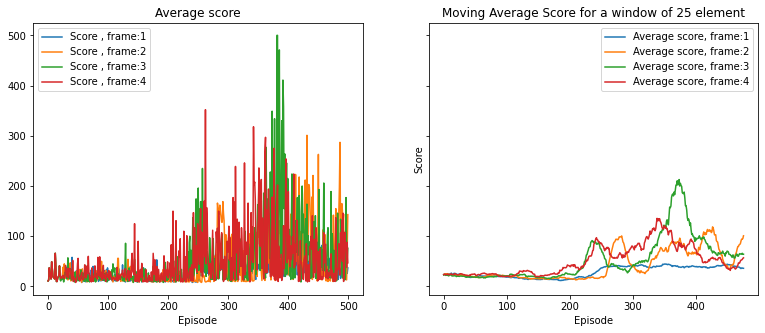

In [39]:
def plot_results_all(r, pr,sw=100):
    fig, ax = plt.subplots(1,2, figsize = (13,5), sharey = True)
    for i in range(len(r)):
        p=pr[i]
        ti = pr[0]
    
        ax[0].plot(np.array(r[i]), label = f'Score , frame:{i+1}')
        
        mv=np.convolve(r[i], np.ones(sw), 'valid') / sw
        ax[1].plot(mv, label = f"Average score, frame:{i+1}")
        
       
    ax[1].set_title(f"Moving Average Score for a window of {sw} element")
    ax[0].set_title(f"Average score")

    ax[0].legend()
    ax[0].set_xlabel("Episode")
    ax[1].legend()
    ax[1].set_xlabel("Episode")  
    ax[1].set_ylabel("Score")
    plt.show()
    return
plot_results_all(r, profile,sw=25)

In [60]:
for i in range(len(r)):
    print(f"with number of steps equal to {i}, the average score for the last 300 episode is {np.mean(r[i][200:])}")


with number of steps equal to 0, the average score for the last 300 episode is 35.846666666666664
with number of steps equal to 1, the average score for the last 300 episode is 58.083333333333336
with number of steps equal to 2, the average score for the last 300 episode is 75.89333333333333
with number of steps equal to 3, the average score for the last 300 episode is 69.15666666666667


## Different optimiser

Here I show just this example, however multiple trials has been executed by hand

In [25]:
def initialize_networks(n_frames = 1, action_space_dim = 2, replay_memory_capacity = replay_memory_capacity):

    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQCNN(nf=n_frames)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQCNN(nf=n_frames)
    
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (MSE loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

  0%|          | 0/1000 [00:00<?, ?it/s]

EPISODE: 1 - FINAL SCORE: 13 - Temperature: 4.0
EPISODE: 2 - FINAL SCORE: 26 - Temperature: 3.966866922953173
EPISODE: 3 - FINAL SCORE: 15 - Temperature: 3.934008296104994
EPISODE: 4 - FINAL SCORE: 13 - Temperature: 3.901421846110568
EPISODE: 5 - FINAL SCORE: 11 - Temperature: 3.869105318455729
EPISODE: 6 - FINAL SCORE: 25 - Temperature: 3.8370564773010587
EPISODE: 7 - FINAL SCORE: 11 - Temperature: 3.8052731053271978
EPISODE: 8 - FINAL SCORE: 23 - Temperature: 3.773753003581442
EPISODE: 9 - FINAL SCORE: 46 - Temperature: 3.742493991325602
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 3.7114939058851326
EPISODE: 11 - FINAL SCORE: 9 - Temperature: 3.6807506024995025
EPISODE: 12 - FINAL SCORE: 28 - Temperature: 3.6502619541738097
EPISODE: 13 - FINAL SCORE: 24 - Temperature: 3.620025851531624
EPISODE: 14 - FINAL SCORE: 41 - Temperature: 3.5900402026690483
EPISODE: 15 - FINAL SCORE: 14 - Temperature: 3.5603029330099885
EPISODE: 16 - FINAL SCORE: 17 - Temperature: 3.5308119851626225
EPISODE:

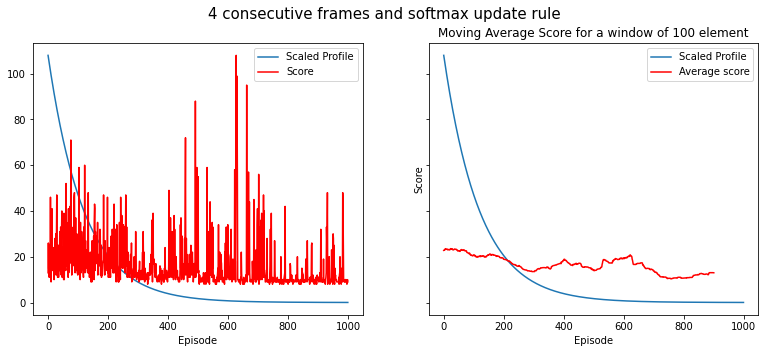

In [26]:
#with SGD and MSELoss
n_frames     = 4
update_type  = 'softmax'
scale        = 0.5 

#initialize the exploration profile
pr = Profile(type = 0, temperature_max = 4 , num_iter= 1000)
profile     = pr._profile()

start_time = time.time()
rsgd, netsgd = training(profile,
                      n_frames = n_frames,
                      update_type = update_type,
                      scale=scale)
end_time   = time.time()

# clear_output(wait = True)
print("training time: ", end_time - start_time, "s")

plot_results(rsgd, profile, n_frames, update_type)